In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocess the labels

In [2]:
import os
path = '/Users/waynewu/4.Github/Clustering-for-scRNAseq/dataset/sc-10x'
if os.path.exists(path):
    files = os.listdir(path)
files

['web_summary.html',
 'filtered_feature_bc_matrix',
 '.DS_Store',
 'raw_feature_bc_matrix',
 'GSM3022245_10x_3cl_metadata.csv',
 'GSM3022245_index_anno.csv',
 'GSM3022245_gene_count.csv',
 'sincell_with_class.RData']

In [3]:
# metadata
ground_truth1 = pd.read_csv(os.path.join(path, files[4]))
# index anno
ground_truth2 = pd.read_csv(os.path.join(path, files[5]), names=['cell_name', 'barcode', 'ref'])
ground_truth1.head(5)

,cell_name,cell_line_demuxlet,demuxlet_cls
0,CELL_001266,H1975,SNG
1,CELL_001391,H2228,DBL
2,CELL_002843,HCC827,DBL
3,CELL_000432,H2228,SNG
4,CELL_001720,HCC827,DBL


In [4]:
ground_truth2.head(5)

,cell_name,barcode,ref
0,CELL_000000,CCTTACGAGGACACCA,864365
1,CELL_000001,CCGTTCAGTACGACCC,755167
2,CELL_000002,TGAAAGACACTGTTAG,753727
3,CELL_000003,CTGAAACAGAGACTAT,750591
4,CELL_000004,GACTGCGCACGAAACG,718276


In [5]:
table = ground_truth2.merge(ground_truth1, on='cell_name')
table.head(10)

,cell_name,barcode,ref,cell_line_demuxlet,demuxlet_cls
0,CELL_000001,CCGTTCAGTACGACCC,755167,HCC827,SNG
1,CELL_000002,TGAAAGACACTGTTAG,753727,HCC827,DBL
2,CELL_000003,CTGAAACAGAGACTAT,750591,HCC827,SNG
3,CELL_000004,GACTGCGCACGAAACG,718276,HCC827,SNG
4,CELL_000005,AGCAGCCTCCTCGCAT,701393,HCC827,SNG
5,CELL_000006,TTCTCAAGTTACGACT,665628,H1975,SNG
6,CELL_000007,AGTGTCAGTATCTGCA,663212,HCC827,SNG
7,CELL_000008,TGAGAGGAGATCGATA,656593,HCC827,SNG
8,CELL_000009,TTCGAAGGTTCCGTCT,652084,HCC827,SNG
9,CELL_000010,CTCATTACATTCCTCG,651956,HCC827,SNG


# Compare results

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/waynewu/4.Github/Clustering-for-scRNAseq/cluster_results/sc-10x/'
barcode = 'barcode'

# 1. seurat python 10x
py_10x = pd.read_csv(path+'seurat-python.csv')
py_10x.pop('Unnamed: 0')

# 2. seurat r 10x - resolution = 1
R_10x = pd.read_csv(path+'seurat-R-1.csv')
R_10x[barcode] = R_10x['Unnamed: 0']
R_10x.pop('Unnamed: 0')
newdata = table.merge(R_10x, on=barcode)
newdata['target'] = newdata['cell_line_demuxlet'].factorize()[0]

# 3. sc3 results
sc3 = pd.read_excel(path+'sc3_results.xls')
sc3_results = sc3[["Unnamed: 0", "sc3_4_clusters"]]
sc3_results[barcode] = sc3_results["Unnamed: 0"]
sc3_r = table.merge(sc3_results, on=barcode)
sc3_r['target'] = sc3_r['cell_line_demuxlet'].factorize()[0]

# 4. cooc results
cooc = pd.read_csv(path+'cooc.csv').T.reset_index()[1:]
cooc[barcode] = cooc["index"]
cooc["cooc_clusters"] = cooc.loc[:,0]
cooc.pop("index")
cooc.pop(0)
cooc_data = table.merge(cooc, on=barcode)
cooc_data['target'] = cooc_data['cell_line_demuxlet'].factorize()[0]

# 5. RaceID3
race = pd.read_csv(path+'RaceID3.csv')
race[barcode] = race["Unnamed: 0"]
race.pop("Unnamed: 0")
race_data = table.merge(race, on=barcode)
race_data['target'] = race_data['cell_line_demuxlet'].factorize()[0]

# 6. SAFE clustering
safe = pd.read_csv(path+'SAFE.csv')
safe[barcode] = safe["Unnamed: 0"]
safe.pop("Unnamed: 0")
safe_data = table.merge(safe, on=barcode)
safe_data['target'] = safe_data['cell_line_demuxlet'].factorize()[0]

## 1. Cluster counts

In [10]:
def cluster_counts(df, cluster_name, name):
    print("Cluster counts for {}".format(name))
    groups = df.groupby(by = cluster_name)
    return groups["target"].describe()[['count']]

In [1]:
#cluster_counts(py_10x, 'louvain', '1. seurat python 10x - 3 cells')

In [2]:
#cluster_counts(newdata, 'seurat_clusters', '2. seurat r 10x - 3 cells - resolution = 1')

In [4]:
#cluster_counts(sc3_r, 'sc3_4_clusters', '3. sc3 10x')

In [5]:
#cluster_counts(cooc_data, 'cooc_clusters', '4. cooc 10x')

In [30]:
# 5. RaceID3
counts = race_data['V1'].value_counts()
race_data = race_data[~race_data['V1'].isin(counts[counts < 20].index)]
cluster_counts(race_data, 'V1', '6. RaceID3 10x')

Cluster counts for 6. RaceID3 10x


,count
V1,
1,82.0
2,165.0
3,134.0
4,114.0
5,145.0
7,109.0
8,21.0
9,59.0
10,41.0


In [7]:
# cluster_counts(safe_data, 'V1', '6. SAFE 10x')

## 2. Compare with ground truths

In [24]:
def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in range(len(df.columns))}
    dic = sorted(dic.items(), key = lambda x: x[1])
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

In [25]:
# 1. seurat python 10x - 3 cells 
df = pd.crosstab(py_10x['target'], py_10x['louvain'])
df_s = df.copy()
df_s["sum"] = df.sum(axis=1)
df_s

louvain,0,1,2,3,4,5,6,7,8,9,sum
target,,,,,,,,,,,
0,0,0,134,111,0,0,0,0,0,33,278
1,144,137,0,0,0,0,0,38,0,0,319
2,0,0,0,0,104,95,80,0,38,1,318


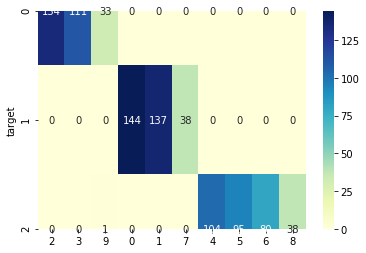

In [26]:
df = reorder(df)
sns.heatmap(df, cmap="YlGnBu", annot=True, fmt="d")

In [27]:
# 2. seurat r 10x - 3 cells - resolution = 1
df_r = pd.crosstab(newdata['target'], newdata['seurat_clusters'])
df_r_s = df_r.copy()
df_r_s["sum"] = df_r.sum(axis=1)
df_r_s

seurat_clusters,0,1,2,3,4,5,6,7,8,9,sum
target,,,,,,,,,,,
0,150,128,0,0,0,0,0,0,0,0,278
1,1,0,117,0,91,0,66,0,0,44,319
2,0,0,0,113,0,86,0,61,58,0,318


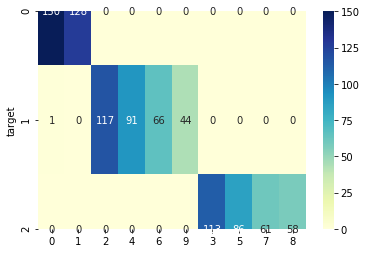

In [28]:
df_r = reorder(df_r)
sns.heatmap(df_r, cmap="YlGnBu", annot=True, fmt="d")

In [29]:
# 3. sc3 10x
df_sc3 = pd.crosstab(sc3_r['target'], sc3_r['sc3_4_clusters'])
df_sc3_s = df_sc3.copy()
df_sc3_s["sum"] = df_sc3_s.sum(axis=1)
df_sc3_s

sc3_4_clusters,1,2,3,4,sum
target,,,,,
0,0,317,0,0,317
1,0,1,188,169,358
2,322,0,0,0,322


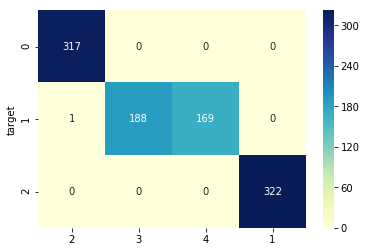

In [18]:
def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in range(1, len(df.columns)+1)}
    dic = sorted(dic.items(), key = lambda x: x[1])
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

df_sc3 = reorder(df_sc3)
sns.heatmap(df_sc3, cmap="YlGnBu", annot=True, fmt="d")

In [34]:
# 4. cooc - 3 cells 
df_cooc = pd.crosstab(cooc_data['target'], cooc_data[cooc_data['cooc_clusters']<9]['cooc_clusters'])
df_cooc_s = df_cooc.copy()
df_cooc_s["sum"] = df_cooc.sum(axis=1)
df_cooc_s

cooc_clusters,1,2,3,4,5,6,7,8,sum
target,,,,,,,,,
0,0,1,0,0,36,167,29,40,273
1,2,136,116,60,0,0,0,0,314
2,310,0,0,0,0,0,0,0,310


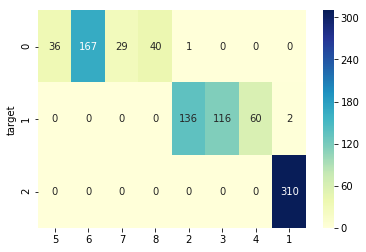

In [20]:
def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in range(1, len(df.columns)+1)}
    dic = sorted(dic.items(), key = lambda x: x[1])
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

df_cooc = reorder(df_cooc)
sns.heatmap(df_cooc, cmap="YlGnBu", annot=True, fmt="d")

In [32]:
# 5. RaceID3
df_race = pd.crosstab(race_data['target'], race_data['V1'])
df_race_s = df_race.copy()
df_race_s["sum"] = df_race.sum(axis=1)
df_race_s

V1,1,2,3,4,5,6,7,8,9,10,...,67,68,69,70,71,72,73,74,75,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0,165,0,0,1,5,108,0,0,0,...,1,0,0,5,1,0,1,0,0,317
1,0,0,134,114,0,0,1,21,0,41,...,0,0,1,0,0,1,0,1,1,358
2,82,0,0,0,144,0,0,0,59,0,...,0,1,0,0,0,0,0,0,0,322


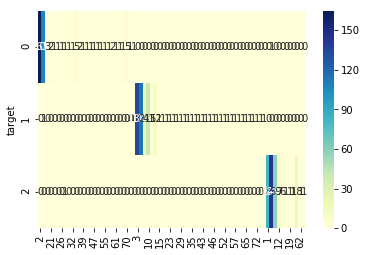

In [22]:
def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in range(1, len(df.columns)+1) if i != 6}
    dic = sorted(dic.items(), key = lambda x: x[1])
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

df_race = reorder(df_race)
sns.heatmap(df_race, cmap="YlGnBu", annot=True, fmt="d")

In [10]:
# 7. SAFE
df_safe = pd.crosstab(safe_data['target'], safe_data['V1'])
df_safe_s = df_safe.copy()
df_safe_s["sum"] = df_safe.sum(axis=1)
df_safe_s

V1,1,2,3,4,5,6,sum
target,,,,,,,
0,0,0,0,0,277,40,317
1,205,20,0,131,1,1,358
2,0,0,318,0,0,4,322


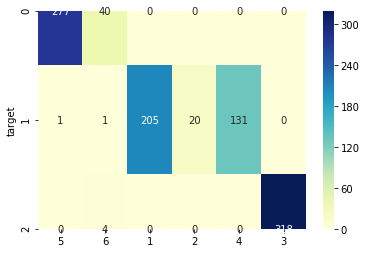

In [11]:
def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in range(1, len(df.columns)+1)}
    dic = sorted(dic.items(), key = lambda x: x[1])
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

df_safe = reorder(df_safe)
sns.heatmap(df_safe, cmap="YlGnBu", annot=True, fmt="d")

## 3. mutual comparison

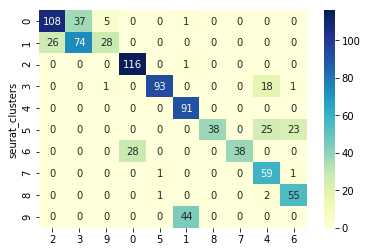

In [87]:
# python vs. r (resolution: 1)
dfsss = pd.crosstab(newdata['seurat_clusters'], py_10x['louvain'])
dfsss = reorder(dfsss)
sns.heatmap(dfsss, cmap="YlGnBu", annot=True, fmt="d")

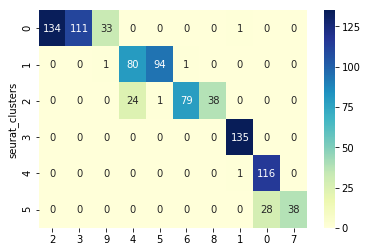

In [88]:
# mutual comparison
# python vs. r (resolution: 0.5)
dfsss = pd.crosstab(newdata_half['seurat_clusters'], py_10x['louvain'])
dfsss = reorder(dfsss)
sns.heatmap(dfsss, cmap="YlGnBu", annot=True, fmt="d")

## 4. Calculating the metrics
With M and N representing the cluster
assignment generated from clustering methods and annotations (ground truth), we
define these measures as follows:

<img src="clustering.png"/>

where $x_j$ are cells in the jth true cluster and $p(x_j)$ are the proportions of these
cells relative to the total number of cells in the ith generated cluster. For $H_{accuracy}$,
M denotes the clustering generated by a given method, and $Ni$ are the true clusters
in the ith generated cluster. Similarly, in $H_{purity}$, N denotes the true clusters while
$M_i$ is the method assigned cluster for the ith true cluster. The ECA measures the
diversity of the true group labels within each cluster assigned by the clustering
algorithm. A low value indicates that the cells in a cluster identified by a given
method are homogeneous and from the same group.

In [35]:
def calc_h_accuracy(df):
    df_norm = df.apply(lambda x: x/x.sum(), axis=0)
    df_entropy = df_norm.apply(lambda x: x*np.log2(x+0.0001))
    return -np.sum(df_entropy.sum(axis=0)) / len(df.columns)

def calc_h_purity(df):
    df_norm = df.apply(lambda x: x/x.sum(), axis=1)
    df_entropy = df_norm.apply(lambda x: x*np.log2(x+0.0001))
    return -np.sum(df_entropy.sum(axis=0)) / len(df)

In [36]:
print("======10x single cell results======")
print("The entropy of cluster accuracy for seurat python: {:.5f}".format(calc_h_accuracy(df)))
print("The entropy of cluster accuracy for seurat R (resolution=1): {:.5f}".format(calc_h_accuracy(df_r)))
print("The entropy of cluster accuracy for sc3: {:.5f}".format(calc_h_accuracy(df_sc3)))
print("The entropy of cluster accuracy for cooc: {:.5f}".format(calc_h_accuracy(df_cooc)))
print("The entropy of cluster accuracy for RaceID3: {:.5f}".format(calc_h_accuracy(df_race)))
print("The entropy of cluster accuracy for SAFE: {:.5f}".format(calc_h_accuracy(df_safe)))

======10x single cell results======
The entropy of cluster accuracy for seurat python: 0.01898
The entropy of cluster accuracy for seurat R (resolution=1): 0.00559
The entropy of cluster accuracy for sc3: 0.00749
The entropy of cluster accuracy for cooc: 0.01460
The entropy of cluster accuracy for RaceID3: 0.01498
The entropy of cluster accuracy for SAFE: 0.10276


In [27]:
print("======10x single cell results======")
print("The entropy of cluster purity for seurat python: {:.5f}".format(calc_h_purity(df)))
print("The entropy of cluster purity for seurat R (resolution=1): {:.5f}".format(calc_h_purity(df_r)))
print("The entropy of cluster purity for sc3: {:.5f}".format(calc_h_purity(df_sc3)))
print("The entropy of cluster purity for cooc: {:.5f}".format(calc_h_purity(df_cooc)))
print("The entropy of cluster purity for RaceID3: {:.5f}".format(calc_h_purity(df_race)))
print("The entropy of cluster purity for SAFE: {:.5f}".format(calc_h_purity(df_safe)))

======10x single cell results======
The entropy of cluster purity for seurat python: 1.58279
The entropy of cluster purity for seurat R (resolution=1): 1.62559
The entropy of cluster purity for sc3: 0.34072
The entropy of cluster purity for cooc: 1.05109
The entropy of cluster purity for RaceID3: 2.21876
The entropy of cluster purity for SAFE: 1.05873


#### Rand index adjusted for chance

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

$ARI = \frac{RI - Expected\{RI\}}{max(RI) - Expected\{RI\}}$

The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

#### For example:
real class set is U, cluster result set is V:

Randomly choose two points:

1) both belongs to U, V: a $\sum_{ij}{C^{n_{ij}}_2}$

2) both belongs to U, but not V: b $\sum_{i}{C^{n_{i}}_2} - \sum_{ij}{C^{n_{ij}}_2}$

3) both belongs to V, but not U: c $\sum_{j}{C^{n_{j}}_2} - \sum_{ij}{C^{n_{ij}}_2}$

4) both don't belong to U,V: d $\sum{C^{n}_2}$


<img src="ari.png" width="400"/>

In [28]:
from sklearn.metrics.cluster import adjusted_rand_score
print("======10x single cell 3 cell lines results======")
print("The ARI for seurat python: {:.5f}".format(adjusted_rand_score(py_10x['target'], py_10x['louvain'])))
print("The ARI for seurat R (resolution=1): {:.5f}".format(adjusted_rand_score(newdata['target'], newdata['seurat_clusters'])))
print("The ARI for sc3: {:.5f}".format(adjusted_rand_score(sc3_r['target'], sc3_r['sc3_4_clusters'])))
print("The ARI for cooc: {:.5f}".format(adjusted_rand_score(cooc_data['target'], cooc_data['cooc_clusters'])))
print("The ARI for RaceID3: {:.5f}".format(adjusted_rand_score(race_data['target'], race_data['V1'])))
print("The ARI for SAFE: {:.5f}".format(adjusted_rand_score(safe_data['target'], safe_data['V1'])))

======10x single cell 3 cell lines results======
The ARI for seurat python: 0.42268
The ARI for seurat R (resolution=1): 0.40055
The ARI for sc3: 0.84564
The ARI for cooc: 0.55834
The ARI for RaceID3: 0.37315
The ARI for SAFE: 0.60380
